# DSCI 573 - Feature and Model Selection

# Lab 4: A mini project - Putting it all together

## Table of contents
0. [Submission instructions](#si) (4%)
1. [Understanding the problem](#1) (4%)
2. [Data splitting](#2) (2%)
3. [EDA](#3) (10%)
4. (Optional) [Feature engineering](#4)
5. [Preprocessing and transformations](#5) (10%)
6. [Baseline model](#6) (2%)
7. [Linear models](#7) (10%)
8. [Different models](#8) (16%)
9. (Optional) [Feature selection](#9)
10. [Hyperparameter optimization](#10) (10%)
11. [Interpretation and feature importances](#11) (10%)
12. [Results on the test set](#12) (10%)
13. [Summary of the results](#13) (12%)
15. (Optional) [Reproducible data analysis pipeline](#14)
15. (Optional) [Your takeaway from the course](#15)

## Submission instructions <a name="si"></a>
<hr>
rubric={mechanics:4}

You will receive marks for correctly submitting this assignment. To submit this assignment, follow the instructions below:

- **Which problem did you pick, classification or regression?** Classification
- **Report your test score here along with the metric used:** 
- **Please add a link to your GitHub repository here: https://github.ubc.ca/mds-2021-22/DSCI_573_lab4_danhkkin**
- **You don't have to but you may work on this assignment in a group (group size <= 4) and submit your assignment as a group.** 
- Below are some instructions on working as a group.  
    - The maximum group size is 4. 
    - You can choose your own group members. Since I don't know your groups in advance, I am not opening this lab as a group lab. So you all will have a separate GitHub repository for your labs and you'll have to decide how you want to collaborate. 
    - Use group work as an opportunity to collaborate and learn new things from each other. 
    - Be respectful to each other and make sure you understand all the concepts in the assignment well. 
    - It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. [Here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members) are some instructions on adding group members in Gradescope.  
- Be sure to follow the [general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions/).
- Make at least three commits in your lab's GitHub repository.
- Push the final .ipynb file with your solutions to your GitHub repository for this lab.
- Upload the .ipynb file to Gradescope.
- If the .ipynb file is too big or doesn't render on Gradescope for some reason, also upload a pdf or html in addition to the .ipynb. 
- Make sure that your plots/output are rendered properly in Gradescope.

> [Here](https://github.com/UBC-MDS/public/tree/master/rubric) you will find the description of each rubric used in MDS.

> As usual, do not push the data to the repository. 

## Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.impute import SimpleImputer
# from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
)

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
# from sklearn.tree import DecisionTreeRegressor, export_graphviz

from pandas_profiling import ProfileReport

import altair as alt

from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

import shap
from catboost import CatBoostClassifier
# from lightgbm.sklearn import LGBMRegressor
# from xgboost import XGBRegressor

# from sklearn.ensemble import VotingRegressor
# from sklearn.ensemble import StackingRegressor
%matplotlib inline

In [2]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

## Introduction <a name="in"></a>

In this lab you will be working on an open-ended mini-project, where you will put all the different things you have learned so far in 571 and 573 together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips
1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 

#### Assessment
We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.


#### A final note
Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (2-8 hours???) is a good guideline for a typical submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

## 1. Pick your problem and explain what exactly you are trying to predict <a name="1"></a>
<hr>
rubric={reasoning:4}

In this mini project, you will pick one of the following problems: 

- A classification problem of predicting whether a credit card client will default or not. For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. You may take some ideas and compare your results with [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719), which is available through [the UBC library](https://www.library.ubc.ca/). 

OR 

- A regression problem of predicting `reviews_per_month`, as a proxy for the popularity of the listing with [New York City Airbnb listings from 2019 dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data). Airbnb could use this sort of model to predict how popular future listings might be before they are posted, perhaps to help guide hosts create more appealing listings. In reality they might instead use something like vacancy rate or average rating as their target, but we do not have that available here.

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. Write a few sentences on your initial thoughts on the problem and the dataset. 
2. Download the dataset and read it as a pandas dataframe. 
3. Carry out any preliminary preprocessing, if needed (e.g., changing feature names, handling of NaN values etc.)

**1.1 Answer** The credit card default dataset contains 24 features and the target column, `default.payment.month`. Of the 24 features, there are three main categories present: categorical, numeric, and binary. The only feature to be droppped is `ID`, which is the unique identifier of each client, and therefore not a useful feature. In the original dataset the categorical columns have numeric values corresponding to specific categories. Therefore, the categorical variables `EDUCATION` and `MARRIAGE` require preprocessing to explicitly name the categories, as well as combine ambiguous 'Other'/'Unknown' categories. While technically categorical, `SEX` will be treated as a binary value. 

In [3]:
cred_df = pd.read_csv("data/UCI_Credit_Card.csv")

cred_df.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default.payment.next.month  
0       0.0       0.0       0.0                           1  
1    1000.0       0.0    2000.0                           1  
2    1000.0    1000.0    5000.0                           0  
3    1100.0    1069.0    1000.0                           0  
4    9000.0     689.0     679.0                           0  

[5 rows x 25 columns]

In [4]:
cred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [5]:
cred_df["EDUCATION"].unique()

array([2, 1, 3, 5, 4, 6, 0])

For the feature, `EDUCATION`, 1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, and 6=unknown. Since 0 is not given a definition and 5 and 6 are also defined as unknown, we decided to combine 0, 5, and 6 into the others category with 4.

In [6]:
cred_df["EDUCATION"] = cred_df["EDUCATION"].apply(
    lambda x:
    "Other" if x in {0, 4, 5, 6}
    else "Grad_school" if x == 1
    else "University" if x == 2
    else "High_school")

In [7]:
cred_df["SEX"].unique()

array([2, 1])

For the feature, `SEX`, 1=male and 2=female. Here we decided to explicitly translate these numbers into their corresponding categories.

In [8]:
cred_df["SEX"] = cred_df["SEX"].apply(
    lambda x: "Male" if x == 1 else "Female")

In [9]:
cred_df["MARRIAGE"].unique()

array([1, 2, 3, 0])

For the feature, `MARRIAGE`, 1=married, 2=single, and 3=others. There is another value, 0, which is not defined and so we decided to put it in the other category with 3, and translate all of the numbers into their corresponding categories.

In [10]:
cred_df["MARRIAGE"] = cred_df["MARRIAGE"].apply(
    lambda x:
    "Married" if x == 1
    else "Single" if x == 2
    else "Other")

<br><br>

## 2. Data splitting <a name="2"></a>
<hr>
rubric={reasoning:2}

**Your tasks:**

1. Split the data into train and test portions.

> Make decision on the `test_size` based on the capacity of your laptop. Don't forget to use a random state.  

In [11]:
target = "default.payment.next.month"

In [12]:
train_df, test_df = train_test_split(cred_df, test_size=0.5, random_state=123)

In [13]:
X_train, y_train = train_df.drop(columns=[target]), train_df[target]
X_test, y_test = test_df.drop(columns=[target]), test_df[target]

<br><br>

## 3. EDA <a name="3"></a>
<hr>
rubric={viz:4,reasoning:6}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

In [14]:
# profile = ProfileReport(X_train, title="Pandas Profiling Report")

# profile

We performed initial EDA on the trainset using Pandas profiling. 

Please note that the inclusion seems to make the notebook unstable so for now we are commenting the cell and leave it to the reader to run if they would like to reproduce the work. 

### Summary statistic 1

In [15]:
print(f"Instances of fraud make up {round(y_train.value_counts()[1] / y_train.value_counts()[0] * 100, 2)}% of the training data.")

Instances of fraud make up 28.89% of the training data.


Here we see that fraudelent observations are just over a quarter of the data, meaning that class imbalance is not too severe of a problem. 

### Summary statistic 2

In [16]:
bill_df = X_train[[
    "BILL_AMT1",
    "BILL_AMT2",
    "BILL_AMT3",
    "BILL_AMT4",
    "BILL_AMT5",
    "BILL_AMT6"]]

pd.DataFrame(bill_df.mean())[0].apply(lambda x: "NT${:.1f}k".format((x/1000)))

BILL_AMT1    NT$50.8k
BILL_AMT2    NT$48.9k
BILL_AMT3    NT$46.6k
BILL_AMT4    NT$43.1k
BILL_AMT5    NT$40.0k
BILL_AMT6    NT$38.3k
Name: 0, dtype: object

Here we see the mean of each monthly bill in the data, in which we observe a declining trend. 

### Visualizations

In [17]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [18]:
alt.Chart(X_train).mark_bar().encode(
     alt.X(alt.repeat(), type='quantitative', bin=alt.Bin(maxbins=30)),
     y='count()'
).properties(
    width=300,
    height=200
).repeat(
    ["LIMIT_BAL",
     "AGE",
     "PAY_0",
     "BILL_AMT1",
     "PAY_AMT1"],
    columns=2
).properties(
    title="Facet counts of observations for numeric features")

alt.RepeatChart(...)

Here we give count observations for our numeric variables (one per time cluster)--nothing seems to suggest faulty data. 

In [19]:
corr_df = (
    X_train.drop("ID", axis=1)
    .corr("spearman")
    .stack()  # Get df into long format for altair
    .reset_index(name="corr")
)  # Name the index that is reset to avoid name collision

alt.Chart(corr_df, title="Correlation Matrix of Numeric Features").mark_circle().encode(
    x="level_0",
    y="level_1",
    size=alt.Size("corr", legend=None),
    color=alt.Color("corr", scale=alt.Scale(domain=(-1, 1), scheme="purpleorange"))
)

alt.Chart(...)

Here we observe the correlation among our numeric variables, with the most clustering of correlation around the same variables across different months.

### Summarized Findings from EDA

We found from the profiling report that there were some field encodings which were cause for concern. We note that the education levels contain some unknown levels which are not described in the documentation. This makes the field better suited to a categorical feature rather than an ordinal feature.

From our summary statistics, we find that there are a relatively large amount of fraud instances in the data compared to what we would expect in real life. This is good from a model training perspective as we will have many examples on which to train. It is unlikely that class imbalance will be a problem in our analysis. 

Moreover, we see in the monthly bills summary that there is an increasing average bill month to month. Please note that bill 6 is April 2005 while bill 1 is September 2005. This could be evidence of seasonality in the data if this is typical from year to year. Alternatively it could be evidence of some facet of the Taiwanese economy during the observed time period. We note that this may cause some problems if attempting to apply models used in this analysis outside of the context of this study.

From our visualizations, we see firstly that most of our age is right skewed. Our limit balance, bill statements, previous payment amounts are all approximately exponentially distributed, which is to be expected given the inequality of income we would expect in a random selection of people. 

The interpretation of the repayment status variables are complicated given that negative one indicate duly paid status, positive numbers indicate delay, and negative two and zero are not explained in the documentation. The distribution has a right skew and a large peak at 0 but does have some symmetry, where most people fully pay off or are close to fully paying off their bill and the number of people with payment delay is inversely proportionate to the length of the payment delay. This assumes that -2 and 0 are categories semantically related to -1. Because of this order in the data it seems like a safe decision to keep the repayment status variables numeric, and not turn them into categories.

The correlation matrix seems to corroborate our initial thoughts that the time series nature of the data will cause multicollinearity in the data. There are clear clusters around the same type of variables across different months, and there are also clusters of correlation across our bill and pay-related variables except for repayment status and payment amount. Curiously, age and limit balance seem to show relatively little correlation with other features. 

Given that we are interested in the positive classification of fraud, we will select the following scoring metrics to make sure that we understand the nature of the mistakes that the model may make ("recall", "precision"), an overall score at the default threshold ("f1"), and information on which model may be best to proceed with for threshold optimization ("roc_auc").

In [20]:
scoring_metrics = ["accuracy", "f1", "recall", "precision", "roc_auc"]

<br><br>

## (Optional) 4. Feature engineering <a name="4"></a>
<hr>
rubric={reasoning:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

**Average Credit Ratio:** The feature created in this step is `avg_credit_ratio`, which is the average bill amount (over 6 months) divided by the total credit limit available to each customer. 
- An analysis is conducted in this step including `avg_credit_ratio` as a feature, however, in the interest of time, the rest of the lab will be conducted without this engineered feature. 

In [21]:
bill_list = ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]

train_df["bill_avg"] = train_df[bill_list].mean(axis = 1)
train_df["avg_credit_ratio"] = train_df["bill_avg"] / train_df["LIMIT_BAL"]

test_df["bill_avg"] = test_df[bill_list].mean(axis = 1)
test_df["avg_credit_ratio"] = test_df["bill_avg"] / test_df["LIMIT_BAL"]


# split data again w new features
X_train, y_train = train_df.drop(columns=[target, "bill_avg"]), train_df[target]
X_test, y_test = test_df.drop(columns=[target, "bill_avg"]), test_df[target]


Preprocessing:

In [22]:
new_numeric_feats = [
    "LIMIT_BAL",
    "AGE",
    "PAY_0",
    "PAY_2",
    "PAY_3",
    "PAY_4",
    "PAY_5",
    "PAY_6",
    "BILL_AMT1",
    "BILL_AMT2",
    "BILL_AMT3",
    "BILL_AMT4",
    "BILL_AMT5",
    "BILL_AMT6",
    "PAY_AMT1",
    "PAY_AMT2",
    "PAY_AMT3",
    "PAY_AMT4",
    "PAY_AMT5",
    "PAY_AMT6",
    "avg_credit_ratio"
]
categorical_feats = ["MARRIAGE", "EDUCATION"]
binary_feats = ["SEX"]
drop_feats =  ["ID"]

fe_ct = make_column_transformer(
    (StandardScaler(), new_numeric_feats),
    (OneHotEncoder(sparse=False, handle_unknown="ignore"), categorical_feats),
    (OneHotEncoder(sparse=False, handle_unknown="ignore", drop="if_binary"), binary_feats),
    ("drop", drop_feats)
)

Dummy Classifier baseline:

In [23]:
results = {}
fe_dummy_pipe = make_pipeline(
    fe_ct,
    DummyClassifier()
)

results["Dummy"] = mean_std_cross_val_scores(
    fe_dummy_pipe, X_train, y_train, scoring=scoring_metrics, return_train_score=True
)

pd.DataFrame(results)

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Dummy
fit_time         0.018 (+/- 0.006)
score_time       0.015 (+/- 0.005)
test_accuracy    0.776 (+/- 0.000)
train_accuracy   0.776 (+/- 0.000)
test_f1          0.000 (+/- 0.000)
train_f1         0.000 (+/- 0.000)
test_recall      0.000 (+/- 0.000)
train_recall     0.000 (+/- 0.000)
test_precision   0.000 (+/- 0.000)
train_precision  0.000 (+/- 0.000)
test_roc_auc     0.500 (+/- 0.000)
train_roc_auc    0.500 (+/- 0.000)

Linear Model:

In [24]:
fe_lr_pipe = make_pipeline(
    fe_ct, LogisticRegression(random_state=123, n_jobs=-1, max_iter=1000)
)

results["Logistic Regression"] = mean_std_cross_val_scores(
    fe_lr_pipe, X_train, y_train, scoring=scoring_metrics, return_train_score=True
)

pd.DataFrame(results)

Dummy Logistic Regression
fit_time         0.018 (+/- 0.006)   0.572 (+/- 0.227)
score_time       0.015 (+/- 0.005)   0.021 (+/- 0.004)
test_accuracy    0.776 (+/- 0.000)   0.810 (+/- 0.004)
train_accuracy   0.776 (+/- 0.000)   0.811 (+/- 0.002)
test_f1          0.000 (+/- 0.000)   0.378 (+/- 0.017)
train_f1         0.000 (+/- 0.000)   0.382 (+/- 0.013)
test_recall      0.000 (+/- 0.000)   0.258 (+/- 0.015)
train_recall     0.000 (+/- 0.000)   0.261 (+/- 0.012)
test_precision   0.000 (+/- 0.000)   0.709 (+/- 0.031)
train_precision  0.000 (+/- 0.000)   0.715 (+/- 0.007)
test_roc_auc     0.500 (+/- 0.000)   0.728 (+/- 0.014)
train_roc_auc    0.500 (+/- 0.000)   0.732 (+/- 0.003)

Linear hyperparameter optimization:

In [25]:
grid = {
    'logisticregression__C': 10.0 ** np.arange(-3, 5),
    'logisticregression__class_weight': np.array([None, "balanced"])
}

fe_lr_grid_search = GridSearchCV(
    fe_lr_pipe, param_grid=grid, cv=10, scoring="roc_auc", n_jobs=-1
)

fe_lr_grid_search.fit(X_train, y_train);

print(f"The best roc auc score obtained was {fe_lr_grid_search.best_score_}")
print(f"The best score corresponded to the following parameters:\n{fe_lr_grid_search.best_params_}")

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


The best roc auc score obtained was 0.728904145138439
The best score corresponded to the following parameters:
{'logisticregression__C': 100.0, 'logisticregression__class_weight': 'balanced'}


In [26]:
fe_lr_pipe_tuned = make_pipeline(
    fe_ct,
    LogisticRegression(
        random_state=123,
        n_jobs=-1,
        max_iter=1000,
        C=fe_lr_grid_search.best_params_["logisticregression__C"],
        class_weight=fe_lr_grid_search.best_params_["logisticregression__class_weight"],
    ),
)

results["L.R. Tuned"] = mean_std_cross_val_scores(
    fe_lr_pipe_tuned, X_train, y_train, scoring=scoring_metrics, return_train_score=True
)

pd.DataFrame(results)

Dummy Logistic Regression         L.R. Tuned
fit_time         0.018 (+/- 0.006)   0.572 (+/- 0.227)  0.630 (+/- 0.010)
score_time       0.015 (+/- 0.005)   0.021 (+/- 0.004)  0.040 (+/- 0.007)
test_accuracy    0.776 (+/- 0.000)   0.810 (+/- 0.004)  0.695 (+/- 0.008)
train_accuracy   0.776 (+/- 0.000)   0.811 (+/- 0.002)  0.697 (+/- 0.005)
test_f1          0.000 (+/- 0.000)   0.378 (+/- 0.017)  0.486 (+/- 0.012)
train_f1         0.000 (+/- 0.000)   0.382 (+/- 0.013)  0.489 (+/- 0.005)
test_recall      0.000 (+/- 0.000)   0.258 (+/- 0.015)  0.643 (+/- 0.024)
train_recall     0.000 (+/- 0.000)   0.261 (+/- 0.012)  0.646 (+/- 0.003)
test_precision   0.000 (+/- 0.000)   0.709 (+/- 0.031)  0.390 (+/- 0.010)
train_precision  0.000 (+/- 0.000)   0.715 (+/- 0.007)  0.393 (+/- 0.006)
test_roc_auc     0.500 (+/- 0.000)   0.728 (+/- 0.014)  0.729 (+/- 0.013)
train_roc_auc    0.500 (+/- 0.000)   0.732 (+/- 0.003)  0.733 (+/- 0.003)

Trying other models:

In [27]:
models = {
    "knn": make_pipeline(fe_ct, KNeighborsClassifier()),
    "svc": make_pipeline(fe_ct, SVC()),
    "randomforest": make_pipeline(fe_ct, RandomForestClassifier()),
}

for model in models:
    results[model] = mean_std_cross_val_scores(
        models[model],
        X_train,
        y_train,
        scoring=scoring_metrics,
        return_train_score=True,
    )

In [28]:
pd.DataFrame(results)

Dummy Logistic Regression         L.R. Tuned  \
fit_time         0.018 (+/- 0.006)   0.572 (+/- 0.227)  0.630 (+/- 0.010)   
score_time       0.015 (+/- 0.005)   0.021 (+/- 0.004)  0.040 (+/- 0.007)   
test_accuracy    0.776 (+/- 0.000)   0.810 (+/- 0.004)  0.695 (+/- 0.008)   
train_accuracy   0.776 (+/- 0.000)   0.811 (+/- 0.002)  0.697 (+/- 0.005)   
test_f1          0.000 (+/- 0.000)   0.378 (+/- 0.017)  0.486 (+/- 0.012)   
train_f1         0.000 (+/- 0.000)   0.382 (+/- 0.013)  0.489 (+/- 0.005)   
test_recall      0.000 (+/- 0.000)   0.258 (+/- 0.015)  0.643 (+/- 0.024)   
train_recall     0.000 (+/- 0.000)   0.261 (+/- 0.012)  0.646 (+/- 0.003)   
test_precision   0.000 (+/- 0.000)   0.709 (+/- 0.031)  0.390 (+/- 0.010)   
train_precision  0.000 (+/- 0.000)   0.715 (+/- 0.007)  0.393 (+/- 0.006)   
test_roc_auc     0.500 (+/- 0.000)   0.728 (+/- 0.014)  0.729 (+/- 0.013)   
train_roc_auc    0.500 (+/- 0.000)   0.732 (+/- 0.003)  0.733 (+/- 0.003)   

                               knn                svc       randomforest  
fit_time         0.028 (+/- 0.029)  4.125 (+/- 0.055)  2.247 (+/- 0.018)  
score_time       1.250 (+/- 0.069)  2.963 (+/- 0.018)  0.096 (+/- 0.002)  
test_accuracy    0.794 (+/- 0.003)  0.818 (+/- 0.006)  0.814 (+/- 0.008)  
train_accuracy   0.844 (+/- 0.000)  0.826 (+/- 0.002)  1.000 (+/- 0.000)  
test_f1          0.440 (+/- 0.008)  0.459 (+/- 0.020)  0.479 (+/- 0.021)  
train_f1         0.577 (+/- 0.005)  0.485 (+/- 0.007)  0.999 (+/- 0.000)  
test_recall      0.362 (+/- 0.009)  0.344 (+/- 0.019)  0.382 (+/- 0.019)  
train_recall     0.474 (+/- 0.008)  0.365 (+/- 0.007)  0.998 (+/- 0.001)  
test_precision   0.562 (+/- 0.010)  0.690 (+/- 0.029)  0.644 (+/- 0.031)  
train_precision  0.736 (+/- 0.006)  0.723 (+/- 0.009)  1.000 (+/- 0.000)  
test_roc_auc     0.705 (+/- 0.010)  0.734 (+/- 0.007)  0.766 (+/- 0.006)  
train_roc_auc    0.882 (+/- 0.002)  0.807 (+/- 0.003)  1.000 (+/- 0.000)

<br><br>

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

In [29]:
len(X_train.columns)

25

In [30]:
numeric_feats = [
    "LIMIT_BAL",
    "AGE",
    "PAY_0",
    "PAY_2",
    "PAY_3",
    "PAY_4",
    "PAY_5",
    "PAY_6",
    "BILL_AMT1",
    "BILL_AMT2",
    "BILL_AMT3",
    "BILL_AMT4",
    "BILL_AMT5",
    "BILL_AMT6",
    "PAY_AMT1",
    "PAY_AMT2",
    "PAY_AMT3",
    "PAY_AMT4",
    "PAY_AMT5",
    "PAY_AMT6"
]
categorical_feats = ["MARRIAGE", "EDUCATION"]
binary_feats = ["SEX"]
drop_feats =  ["ID"]

In [31]:
ct = make_column_transformer(
    (StandardScaler(), numeric_feats),
    (OneHotEncoder(sparse=False, handle_unknown="ignore"), categorical_feats),
    (OneHotEncoder(sparse=False, handle_unknown="ignore", drop="if_binary"), binary_feats),
    ("drop", drop_feats)
)

<br><br>

## 6. Baseline model <a name="6"></a>
<hr>
rubric={accuracy:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

In [32]:
results = {}

In [33]:
dummy_pipe = make_pipeline(
    ct,
    DummyClassifier()
)

In [34]:
results["Dummy"] = mean_std_cross_val_scores(
    dummy_pipe, X_train, y_train, scoring=scoring_metrics, return_train_score=True
)

pd.DataFrame(results)

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

Dummy
fit_time         0.014 (+/- 0.002)
score_time       0.012 (+/- 0.002)
test_accuracy    0.776 (+/- 0.000)
train_accuracy   0.776 (+/- 0.000)
test_f1          0.000 (+/- 0.000)
train_f1         0.000 (+/- 0.000)
test_recall      0.000 (+/- 0.000)
train_recall     0.000 (+/- 0.000)
test_precision   0.000 (+/- 0.000)
train_precision  0.000 (+/- 0.000)
test_roc_auc     0.500 (+/- 0.000)
train_roc_auc    0.500 (+/- 0.000)

<br><br>

## 7. Linear models <a name="7"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Try a linear model as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the regularization hyperparameter. 
3. Report cross-validation scores along with standard deviation. 
4. Summarize your results.

In [35]:
lr_pipe = make_pipeline(
    ct, LogisticRegression(random_state=123, n_jobs=-1, max_iter=1000)
)

In [36]:
results["Logistic Regression"] = mean_std_cross_val_scores(
    lr_pipe, X_train, y_train, scoring=scoring_metrics, return_train_score=True
)

In [37]:
pd.DataFrame(results)

Dummy Logistic Regression
fit_time         0.014 (+/- 0.002)   0.705 (+/- 0.056)
score_time       0.012 (+/- 0.002)   0.047 (+/- 0.004)
test_accuracy    0.776 (+/- 0.000)   0.811 (+/- 0.005)
train_accuracy   0.776 (+/- 0.000)   0.812 (+/- 0.003)
test_f1          0.000 (+/- 0.000)   0.381 (+/- 0.020)
train_f1         0.000 (+/- 0.000)   0.385 (+/- 0.016)
test_recall      0.000 (+/- 0.000)   0.261 (+/- 0.018)
train_recall     0.000 (+/- 0.000)   0.262 (+/- 0.013)
test_precision   0.000 (+/- 0.000)   0.715 (+/- 0.035)
train_precision  0.000 (+/- 0.000)   0.721 (+/- 0.009)
test_roc_auc     0.500 (+/- 0.000)   0.728 (+/- 0.013)
train_roc_auc    0.500 (+/- 0.000)   0.731 (+/- 0.003)

In [38]:
grid = {
    'logisticregression__C': 10.0 ** np.arange(-3, 5),
    'logisticregression__class_weight': np.array([None, "balanced"])
}

In [39]:
lr_grid_search = GridSearchCV(
    lr_pipe, param_grid=grid, cv=10, scoring="roc_auc", n_jobs=-1
)

In [40]:
lr_grid_search.fit(X_train, y_train);

In [41]:
print(f"The best roc auc score obtained was {lr_grid_search.best_score_}")
print(f"The best score corresponded to the following parameters:\n{lr_grid_search.best_params_}")

The best roc auc score obtained was 0.7285938151852369
The best score corresponded to the following parameters:
{'logisticregression__C': 1000.0, 'logisticregression__class_weight': 'balanced'}


In [42]:
lr_pipe_tuned = make_pipeline(
    ct,
    LogisticRegression(
        random_state=123,
        n_jobs=-1,
        max_iter=1000,
        C=lr_grid_search.best_params_["logisticregression__C"],
        class_weight=lr_grid_search.best_params_["logisticregression__class_weight"],
    ),
)

In [43]:
results["L.R. Tuned"] = mean_std_cross_val_scores(
    lr_pipe_tuned, X_train, y_train, scoring=scoring_metrics, return_train_score=True
)

pd.DataFrame(results)

Dummy Logistic Regression         L.R. Tuned
fit_time         0.014 (+/- 0.002)   0.705 (+/- 0.056)  0.625 (+/- 0.015)
score_time       0.012 (+/- 0.002)   0.047 (+/- 0.004)  0.045 (+/- 0.006)
test_accuracy    0.776 (+/- 0.000)   0.811 (+/- 0.005)  0.688 (+/- 0.008)
train_accuracy   0.776 (+/- 0.000)   0.812 (+/- 0.003)  0.688 (+/- 0.006)
test_f1          0.000 (+/- 0.000)   0.381 (+/- 0.020)  0.483 (+/- 0.011)
train_f1         0.000 (+/- 0.000)   0.385 (+/- 0.016)  0.485 (+/- 0.006)
test_recall      0.000 (+/- 0.000)   0.261 (+/- 0.018)  0.651 (+/- 0.022)
train_recall     0.000 (+/- 0.000)   0.262 (+/- 0.013)  0.656 (+/- 0.006)
test_precision   0.000 (+/- 0.000)   0.715 (+/- 0.035)  0.384 (+/- 0.009)
train_precision  0.000 (+/- 0.000)   0.721 (+/- 0.009)  0.385 (+/- 0.006)
test_roc_auc     0.500 (+/- 0.000)   0.728 (+/- 0.013)  0.728 (+/- 0.013)
train_roc_auc    0.500 (+/- 0.000)   0.731 (+/- 0.003)  0.732 (+/- 0.003)

### Linear model results summary

The initial logistic regression with default values results in a large improvement over the dummy classifier for all relevant scores except for accuracy. This is to be expected given that the dummy classifier's most frequent strategy and that our target variable is mostly non-positive.

We observe a very poor recall and relatively better precision in our base logistic regression. We obtained optimal parameters of a balanced class weight and a C value of 1000 from hyperparameter tuning. In both the optimized and unoptimized cases, we observe remarkably little overfitting, with train and test scores tracking closely.

The optimized parameters did not noticeably improve our ROC AUC, but we achieved a better f1 score by sacrificing some precision and greatly increasing recall. Given that we are interested in identifying fraud, this movement is in the right direction for our model. Ultimately however, a test recall value of just under 70% is not satisfactory for fraud prediction. We cannot accept ~30% of fraud incidences being missed by our algorithm! 

<br><br>

## 8. Different models <a name="8"></a>
<hr>
rubric={accuracy:10,reasoning:6}

**Your tasks:**
1. Try at least 3 other models aside from a linear model. 
2. Summarize your results in terms of overfitting/underfitting and fit and score times. Can you beat a linear model? 

In [44]:
models = {
    "knn": make_pipeline(ct, KNeighborsClassifier()),
    "svc": make_pipeline(ct, SVC()),
    "randomforest": make_pipeline(ct, RandomForestClassifier()),
#     "catboost": make_pipeline(ct, CatBoostClassifier()) 
#     Says on the catboost site to not use OHE with catboost but instead use built in parameters
}

In [45]:
for model in models:
    results[model] = mean_std_cross_val_scores(
        models[model],
        X_train,
        y_train,
        scoring=scoring_metrics,
        return_train_score=True,
    )

In [46]:
pd.DataFrame(results)

Dummy Logistic Regression         L.R. Tuned  \
fit_time         0.014 (+/- 0.002)   0.705 (+/- 0.056)  0.625 (+/- 0.015)   
score_time       0.012 (+/- 0.002)   0.047 (+/- 0.004)  0.045 (+/- 0.006)   
test_accuracy    0.776 (+/- 0.000)   0.811 (+/- 0.005)  0.688 (+/- 0.008)   
train_accuracy   0.776 (+/- 0.000)   0.812 (+/- 0.003)  0.688 (+/- 0.006)   
test_f1          0.000 (+/- 0.000)   0.381 (+/- 0.020)  0.483 (+/- 0.011)   
train_f1         0.000 (+/- 0.000)   0.385 (+/- 0.016)  0.485 (+/- 0.006)   
test_recall      0.000 (+/- 0.000)   0.261 (+/- 0.018)  0.651 (+/- 0.022)   
train_recall     0.000 (+/- 0.000)   0.262 (+/- 0.013)  0.656 (+/- 0.006)   
test_precision   0.000 (+/- 0.000)   0.715 (+/- 0.035)  0.384 (+/- 0.009)   
train_precision  0.000 (+/- 0.000)   0.721 (+/- 0.009)  0.385 (+/- 0.006)   
test_roc_auc     0.500 (+/- 0.000)   0.728 (+/- 0.013)  0.728 (+/- 0.013)   
train_roc_auc    0.500 (+/- 0.000)   0.731 (+/- 0.003)  0.732 (+/- 0.003)   

                               knn                svc       randomforest  
fit_time         0.016 (+/- 0.002)  4.100 (+/- 0.098)  2.181 (+/- 0.050)  
score_time       1.256 (+/- 0.061)  2.943 (+/- 0.012)  0.096 (+/- 0.002)  
test_accuracy    0.793 (+/- 0.002)  0.818 (+/- 0.005)  0.815 (+/- 0.008)  
train_accuracy   0.842 (+/- 0.002)  0.827 (+/- 0.001)  1.000 (+/- 0.000)  
test_f1          0.440 (+/- 0.007)  0.459 (+/- 0.017)  0.484 (+/- 0.020)  
train_f1         0.572 (+/- 0.007)  0.487 (+/- 0.006)  0.999 (+/- 0.000)  
test_recall      0.363 (+/- 0.009)  0.344 (+/- 0.018)  0.387 (+/- 0.019)  
train_recall     0.471 (+/- 0.009)  0.366 (+/- 0.006)  0.998 (+/- 0.001)  
test_precision   0.557 (+/- 0.009)  0.691 (+/- 0.028)  0.647 (+/- 0.032)  
train_precision  0.729 (+/- 0.004)  0.724 (+/- 0.006)  1.000 (+/- 0.000)  
test_roc_auc     0.704 (+/- 0.009)  0.733 (+/- 0.008)  0.764 (+/- 0.006)  
train_roc_auc    0.881 (+/- 0.002)  0.803 (+/- 0.002)  1.000 (+/- 0.000)

**8.2 Answer**

In this step, we compared the optimized logistic regression model against baseline KNN, SVC, and RandomForest classifiers. 

With default hyperparameters, KNN and SVC had similar f-1 and ROC scores as the optimized LR, however, this was the result of decreased recall scores and higher precision. As our priority is identifying fraud, we prioritize improving recall scores above all else. Therefore, the optimized LR performed better than the baseline KNN and SVC.

RandomForest *appears* to display overfitting, however, due to the nature of ensembles, scoring metrics are not as straightforward to interpret. Ensembles circumvent the fundamental tradeoff of model complexity vs. model fit by increasing train score without decreasing validation scores. Therefore, it is best to compare RandomForest's test scores alone, as they are the best indicator of how model will generalize on unseen data. Compared to the tuned LR, RandomForest had similar f-1 and ROC test scores, at the consequence of a lower recall score and a higher precision score. 

Ultimately, neither baseline KNN, SVC, or RandomForest performed better or prioritized identifying fraud as well as the optimized LR model.


<br><br>

## (Optional) 9. Feature selection <a name="9"></a>
<hr>
rubric={reasoning:1}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV`, forward selection or L1 regularization for this. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

In [47]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, Ridge

fs_models = {
    "dummy + rfecv": DummyClassifier(),
    "LR + rfecv" : LogisticRegression(random_state=123, n_jobs=-1, max_iter=1000),
    "LR tuned + rfecv": LogisticRegression(
        random_state=123,
        n_jobs=-1,
        max_iter=1000,
        C=lr_grid_search.best_params_["logisticregression__C"],
        class_weight=lr_grid_search.best_params_["logisticregression__class_weight"],
    ),
    "knn + rfecv": KNeighborsClassifier(),
    "svc + rfecv": SVC(),
    "randomforest + rfecv": RandomForestClassifier()
}

rfecv = {}

for (name, model) in fs_models.items():
    
    pipe_rfecv = make_pipeline(ct, RFECV(Ridge()), model)
    rfecv[name] = mean_std_cross_val_scores(
        pipe_rfecv, X_train, y_train, return_train_score=True, scoring=scoring_metrics
    )

pd.DataFrame(rfecv)



Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

dummy + rfecv         LR + rfecv   LR tuned + rfecv  \
fit_time         0.216 (+/- 0.035)  0.841 (+/- 0.024)  0.804 (+/- 0.038)   
score_time       0.013 (+/- 0.001)  0.044 (+/- 0.003)  0.039 (+/- 0.014)   
test_accuracy    0.776 (+/- 0.000)  0.810 (+/- 0.004)  0.696 (+/- 0.014)   
train_accuracy   0.776 (+/- 0.000)  0.811 (+/- 0.003)  0.696 (+/- 0.006)   
test_f1          0.000 (+/- 0.000)  0.378 (+/- 0.016)  0.488 (+/- 0.015)   
train_f1         0.000 (+/- 0.000)  0.380 (+/- 0.019)  0.489 (+/- 0.004)   
test_recall      0.000 (+/- 0.000)  0.258 (+/- 0.015)  0.646 (+/- 0.020)   
train_recall     0.000 (+/- 0.000)  0.258 (+/- 0.016)  0.647 (+/- 0.009)   
test_precision   0.000 (+/- 0.000)  0.710 (+/- 0.028)  0.393 (+/- 0.015)   
train_precision  0.000 (+/- 0.000)  0.717 (+/- 0.014)  0.393 (+/- 0.006)   
test_roc_auc     0.500 (+/- 0.000)  0.725 (+/- 0.012)  0.726 (+/- 0.012)   
train_roc_auc    0.500 (+/- 0.000)  0.728 (+/- 0.005)  0.729 (+/- 0.005)   

                       knn + rfecv        svc + rfecv randomforest + rfecv  
fit_time         0.216 (+/- 0.022)  3.791 (+/- 0.265)    1.598 (+/- 0.448)  
score_time       0.848 (+/- 0.593)  2.703 (+/- 0.133)    0.100 (+/- 0.003)  
test_accuracy    0.796 (+/- 0.006)  0.819 (+/- 0.003)    0.808 (+/- 0.010)  
train_accuracy   0.841 (+/- 0.003)  0.825 (+/- 0.003)    0.990 (+/- 0.007)  
test_f1          0.456 (+/- 0.011)  0.468 (+/- 0.022)    0.468 (+/- 0.018)  
train_f1         0.577 (+/- 0.012)  0.489 (+/- 0.003)    0.977 (+/- 0.017)  
test_recall      0.381 (+/- 0.013)  0.356 (+/- 0.031)    0.376 (+/- 0.018)  
train_recall     0.483 (+/- 0.016)  0.373 (+/- 0.007)    0.964 (+/- 0.026)  
test_precision   0.569 (+/- 0.023)  0.686 (+/- 0.028)    0.620 (+/- 0.043)  
train_precision  0.716 (+/- 0.011)  0.710 (+/- 0.023)    0.991 (+/- 0.007)  
test_roc_auc     0.710 (+/- 0.010)  0.723 (+/- 0.013)    0.744 (+/- 0.012)  
train_roc_auc    0.879 (+/- 0.005)  0.776 (+/- 0.019)    0.999 (+/- 0.001)

RFECV feature selection scores are similar enough to scores without feature selection that it seems ok to omit this feature in our pipeline.

<br><br>

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. In at least one case you should be optimizing multiple hyperparameters for a single model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) 

In [48]:
# Think about creating a function for the following

In [49]:
X_train.shape

(15000, 25)

In [50]:
knn_grid_search = GridSearchCV(
    models["knn"],
    param_grid={
        'kneighborsclassifier__n_neighbors': np.arange(5, 200, 5)
    },
    cv=10,
    scoring="roc_auc",
    n_jobs=-1
)

In [51]:
knn_grid_search.fit(X_train, y_train);

In [52]:
print(f"The best roc auc score obtained was {knn_grid_search.best_score_:0.4f}")
print(f"The best score corresponded to the following parameters:\n{knn_grid_search.best_params_}")

The best roc auc score obtained was 0.7627
The best score corresponded to the following parameters:
{'kneighborsclassifier__n_neighbors': 165}


In [53]:
svc_random_search = RandomizedSearchCV(
    models["svc"],
    param_distributions={
        "svc__gamma": 10.0 ** np.arange(-3, 4),
        "svc__C": 10.0 ** np.arange(-3, 4),
        "svc__class_weight": np.array([None, "balanced"])
    },
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=123,
    verbose=2
)

In [54]:
svc_random_search.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END svc__C=0.001, svc__class_weight=balanced, svc__gamma=0.01; total time=  22.5s
[CV] END svc__C=0.001, svc__class_weight=balanced, svc__gamma=0.01; total time=  22.8s


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


[CV] END svc__C=0.001, svc__class_weight=balanced, svc__gamma=0.01; total time=  23.0s
[CV] END svc__C=0.001, svc__class_weight=balanced, svc__gamma=0.01; total time=  23.1s
[CV] END svc__C=0.001, svc__class_weight=balanced, svc__gamma=0.01; total time=  23.3s
[CV] END svc__C=1.0, svc__class_weight=balanced, svc__gamma=0.01; total time=  18.6s
[CV] END svc__C=1.0, svc__class_weight=balanced, svc__gamma=0.01; total time=  18.6s
[CV] END svc__C=1.0, svc__class_weight=balanced, svc__gamma=0.01; total time=  19.6s
[CV] END svc__C=0.1, svc__class_weight=None, svc__gamma=0.001; total time=  12.3s
[CV] END svc__C=100.0, svc__class_weight=balanced, svc__gamma=100.0; total time=  58.8s
[CV] END svc__C=1.0, svc__class_weight=balanced, svc__gamma=0.01; total time=  19.0s
[CV] END svc__C=1.0, svc__class_weight=balanced, svc__gamma=0.01; total time=  18.9s
[CV] END svc__C=100.0, svc__class_weight=balanced, svc__gamma=100.0; total time= 1.1min
[CV] END svc__C=100.0, svc__class_weight=balanced, svc__

In [55]:
print(f"The best roc auc score obtained was {svc_random_search.best_score_:0.4f}")
print(f"The best score corresponded to the following parameters:\n{svc_random_search.best_params_}")

The best roc auc score obtained was 0.7603
The best score corresponded to the following parameters:
{'svc__gamma': 0.01, 'svc__class_weight': 'balanced', 'svc__C': 1.0}


In [56]:
forest_random_search = RandomizedSearchCV(
    models["randomforest"],
    param_distributions={
        "randomforestclassifier__n_estimators": np.arange(5, 200, 5),
        "randomforestclassifier__max_depth": np.arange(4, 20, 4),
        "randomforestclassifier__max_features": np.arange(0.1, 1, 0.1),
        "randomforestclassifier__class_weight": np.array([None, "balanced"])
    },
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=123,
    verbose=2
)

In [57]:
forest_random_search.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END randomforestclassifier__class_weight=None, randomforestclassifier__max_depth=16, randomforestclassifier__max_features=0.2, randomforestclassifier__n_estimators=155; total time=   5.4s
[CV] END randomforestclassifier__class_weight=None, randomforestclassifier__max_depth=16, randomforestclassifier__max_features=0.2, randomforestclassifier__n_estimators=155; total time=   5.4s
[CV] END randomforestclassifier__class_weight=None, randomforestclassifier__max_depth=16, randomforestclassifier__max_features=0.2, randomforestclassifier__n_estimators=155; total time=   5.3s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=8, randomforestclassifier__max_features=0.1, randomforestclassifier__n_estimators=60; total time=   0.7s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=8, randomforestclassifier__max_features=0.1, randomforestclassifier__n_esti

In [58]:
print(f"The best roc auc score obtained was {forest_random_search.best_score_:0.4f}")
print(f"The best score corresponded to the following parameters:\n{forest_random_search.best_params_}")

The best roc auc score obtained was 0.7772
The best score corresponded to the following parameters:
{'randomforestclassifier__n_estimators': 60, 'randomforestclassifier__max_features': 0.1, 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__class_weight': 'balanced'}


In [59]:
forest_pipe_tuned = make_pipeline(
    ct,
    RandomForestClassifier(
        n_estimators=forest_random_search.best_params_["randomforestclassifier__n_estimators"],
        max_features=forest_random_search.best_params_["randomforestclassifier__max_features"],
        max_depth=forest_random_search.best_params_["randomforestclassifier__max_depth"],
        class_weight=forest_random_search.best_params_["randomforestclassifier__class_weight"]
    )
)

results["randomforest tuned"] = mean_std_cross_val_scores(
    forest_pipe_tuned, X_train, y_train, scoring=scoring_metrics, return_train_score=True
)

pd.DataFrame(results)

Dummy Logistic Regression         L.R. Tuned  \
fit_time         0.014 (+/- 0.002)   0.705 (+/- 0.056)  0.625 (+/- 0.015)   
score_time       0.012 (+/- 0.002)   0.047 (+/- 0.004)  0.045 (+/- 0.006)   
test_accuracy    0.776 (+/- 0.000)   0.811 (+/- 0.005)  0.688 (+/- 0.008)   
train_accuracy   0.776 (+/- 0.000)   0.812 (+/- 0.003)  0.688 (+/- 0.006)   
test_f1          0.000 (+/- 0.000)   0.381 (+/- 0.020)  0.483 (+/- 0.011)   
train_f1         0.000 (+/- 0.000)   0.385 (+/- 0.016)  0.485 (+/- 0.006)   
test_recall      0.000 (+/- 0.000)   0.261 (+/- 0.018)  0.651 (+/- 0.022)   
train_recall     0.000 (+/- 0.000)   0.262 (+/- 0.013)  0.656 (+/- 0.006)   
test_precision   0.000 (+/- 0.000)   0.715 (+/- 0.035)  0.384 (+/- 0.009)   
train_precision  0.000 (+/- 0.000)   0.721 (+/- 0.009)  0.385 (+/- 0.006)   
test_roc_auc     0.500 (+/- 0.000)   0.728 (+/- 0.013)  0.728 (+/- 0.013)   
train_roc_auc    0.500 (+/- 0.000)   0.731 (+/- 0.003)  0.732 (+/- 0.003)   

                               knn                svc       randomforest  \
fit_time         0.016 (+/- 0.002)  4.100 (+/- 0.098)  2.181 (+/- 0.050)   
score_time       1.256 (+/- 0.061)  2.943 (+/- 0.012)  0.096 (+/- 0.002)   
test_accuracy    0.793 (+/- 0.002)  0.818 (+/- 0.005)  0.815 (+/- 0.008)   
train_accuracy   0.842 (+/- 0.002)  0.827 (+/- 0.001)  1.000 (+/- 0.000)   
test_f1          0.440 (+/- 0.007)  0.459 (+/- 0.017)  0.484 (+/- 0.020)   
train_f1         0.572 (+/- 0.007)  0.487 (+/- 0.006)  0.999 (+/- 0.000)   
test_recall      0.363 (+/- 0.009)  0.344 (+/- 0.018)  0.387 (+/- 0.019)   
train_recall     0.471 (+/- 0.009)  0.366 (+/- 0.006)  0.998 (+/- 0.001)   
test_precision   0.557 (+/- 0.009)  0.691 (+/- 0.028)  0.647 (+/- 0.032)   
train_precision  0.729 (+/- 0.004)  0.724 (+/- 0.006)  1.000 (+/- 0.000)   
test_roc_auc     0.704 (+/- 0.009)  0.733 (+/- 0.008)  0.764 (+/- 0.006)   
train_roc_auc    0.881 (+/- 0.002)  0.803 (+/- 0.002)  1.000 (+/- 0.000)   

                randomforest tuned  
fit_time         0.354 (+/- 0.008)  
score_time       0.039 (+/- 0.003)  
test_accuracy    0.786 (+/- 0.005)  
train_accuracy   0.811 (+/- 0.004)  
test_f1          0.548 (+/- 0.011)  
train_f1         0.606 (+/- 0.004)  
test_recall      0.579 (+/- 0.015)  
train_recall     0.648 (+/- 0.002)  
test_precision   0.520 (+/- 0.010)  
train_precision  0.570 (+/- 0.008)  
test_roc_auc     0.777 (+/- 0.006)  
train_roc_auc    0.841 (+/- 0.002)

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`), or any other methods of your choice, to examine the most important features of one of the non-linear models. 
2. Summarize your observations. 

In [60]:
forest_pipe_tuned.fit(X_train, y_train);

In [61]:
feature_names = np.array(
    numeric_feats
    + forest_pipe_tuned.named_steps["columntransformer"]
    .named_transformers_["onehotencoder-1"]
    .get_feature_names_out().tolist()
    + forest_pipe_tuned.named_steps["columntransformer"]
    .named_transformers_["onehotencoder-2"]
    .get_feature_names_out().tolist()
)

In [62]:
ct.fit(X_train, y_train)
X_train_enc = pd.DataFrame(
    data=ct.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)
X_train_enc.head()

LIMIT_BAL       AGE     PAY_0     PAY_2     PAY_3     PAY_4     PAY_5  \
15936  -0.282085  0.707115  0.011168  0.116066  0.140467 -0.665327 -0.647662   
15248   0.566292 -0.051569  0.011168  0.116066  0.140467  0.187875  0.228346   
27163  -1.207587  0.707115  3.594551  2.634364  1.806082  1.894280  1.980361   
13955   0.334917 -0.701869  0.011168  0.116066  0.140467  0.187875  0.228346   
23604   0.103541 -0.051569 -0.884677 -0.723367 -0.692341 -0.665327 -0.647662   

          PAY_6  BILL_AMT1  BILL_AMT2  ...  PAY_AMT5  PAY_AMT6  \
15936 -0.613298  -0.019121  -0.020511  ... -0.168842 -0.274854   
15248  0.253432   0.490235   0.531287  ...  2.260602 -0.049447   
27163  0.253432  -0.603540  -0.597305  ... -0.291095 -0.267657   
13955  0.253432   2.116870   2.087084  ...  0.363341  0.263529   
23604 -0.613298  -0.541271  -0.522814  ... -0.286343 -0.233871   

       MARRIAGE_Married  MARRIAGE_Other  MARRIAGE_Single  \
15936               0.0             0.0              1.0   
15248               0.0             0.0              1.0   
27163               1.0             0.0              0.0   
13955               0.0             0.0              1.0   
23604               1.0             0.0              0.0   

       EDUCATION_Grad_school  EDUCATION_High_school  EDUCATION_Other  \
15936                    0.0                    0.0              0.0   
15248                    1.0                    0.0              0.0   
27163                    1.0                    0.0              0.0   
13955                    1.0                    0.0              0.0   
23604                    0.0                    0.0              0.0   

       EDUCATION_University  SEX_Male  
15936                   1.0       0.0  
15248                   0.0       0.0  
27163                   0.0       1.0  
13955                   0.0       0.0  
23604                   1.0       0.0  

[5 rows x 28 columns]

In [63]:
X_train.shape

(15000, 25)

In [64]:
# Extract shapely values for a random selection of a third of the training set for speed.
X_train_enc_sample = X_train_enc.sample(5000, random_state=123)

In [65]:
forest_explainer = shap.TreeExplainer(forest_pipe_tuned.named_steps["randomforestclassifier"])
forest_train_shap_values = forest_explainer.shap_values(X_train_enc_sample)

In [66]:
shap.initjs()

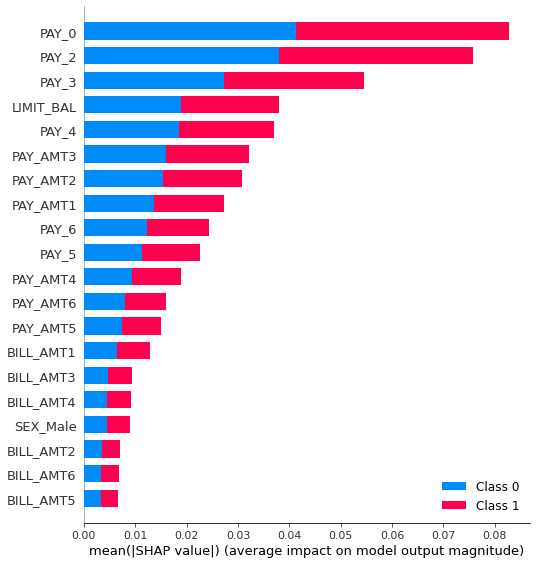

In [67]:
shap.summary_plot(forest_train_shap_values, X_train_enc_sample, plot_type="bar")

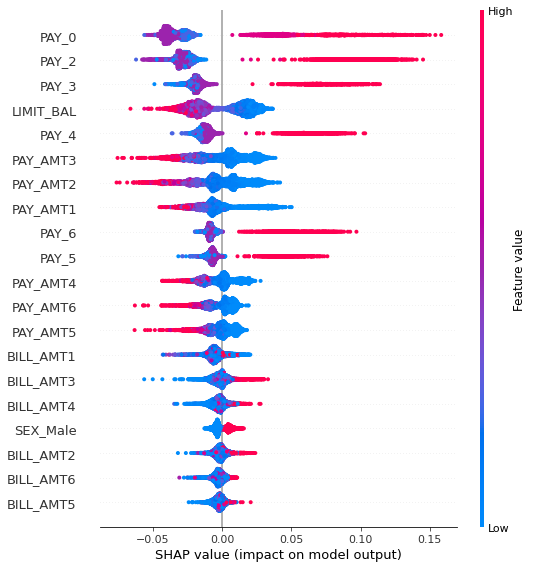

In [68]:
shap.summary_plot(forest_train_shap_values[1], X_train_enc_sample)

Note: Looks like PAY_0 is the most important feature in predicting default, which makes sense because it is the repayment status at the end of the time period recorded (September 2005) and we are predicting whether they will default in the next month (it is expected that the more behind they are on payments, the more likely they are to default within the next month).

<br><br>

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 
3. Take one or two test predictions and explain them with SHAP force plots.  

In [69]:
from sklearn.metrics import get_scorer

score_dict = {
    scorer: [get_scorer(scorer)(forest_pipe_tuned, X_test, y_test)] for scorer in scoring_metrics
}

pd.DataFrame(score_dict)

accuracy        f1    recall  precision   roc_auc
0  0.768267  0.516282  0.566585   0.474182  0.765482

In [70]:
ind = {'test_accuracy' : 'accuracy', 
       'test_f1' :'f1', 
       'test_recall' :'recall', 
       'test_precision':'precision', 
       'test_roc_auc' :'roc_auc'}

# extract CV scores from training
train_scores = pd.DataFrame(results["randomforest tuned"], columns = ["Training Data"]).iloc[2::2, :].rename(index = ind)
test_scores = pd.DataFrame(score_dict).T.rename(columns = {0: "Test Data"})

final_df = pd.concat([train_scores, test_scores], axis = 1)
final_df

Training Data  Test Data
accuracy   0.786 (+/- 0.005)   0.768267
f1         0.548 (+/- 0.011)   0.516282
recall     0.579 (+/- 0.015)   0.566585
precision  0.520 (+/- 0.010)   0.474182
roc_auc    0.777 (+/- 0.006)   0.765482

**Answer 12.2** Yes, the validation scores agree with the test scores! As seen in the above dataframe, the test scores the scores are only a smidge smaller than the CV scores. This is good confirmation that the optimized RandomForestClassifier generalized well. 
- I'm a little weary about overfitting. If we can't rely on the train and CV scores for RandomForestClassifier, how do we measure overfitting?? Would that be a possible issue having to do with optimization? We chose RFC based on CV alone, which I know what Varada said to do, but leaves a lot of room for uncertainty imo


In [71]:
X_test_enc = pd.DataFrame(
    data=ct.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)
X_test_enc.head()

LIMIT_BAL       AGE     PAY_0     PAY_2     PAY_3     PAY_4     PAY_5  \
25665  -0.976212 -1.027019 -0.884677  0.116066  0.140467  0.187875 -0.647662   
16464  -0.667711  2.549632  0.011168  0.116066  0.140467  0.187875  0.228346   
22386   0.026416 -0.593486  1.802860  1.794931  1.806082  1.894280  1.980361   
10149   0.257792  0.598731 -1.780523 -1.562800 -1.525149 -1.518530 -1.523669   
8729   -0.899086  0.815498  0.011168  0.116066  0.140467  0.187875  0.228346   

          PAY_6  BILL_AMT1  BILL_AMT2  ...  PAY_AMT5  PAY_AMT6  \
25665  0.253432  -0.298475  -0.345146  ... -0.269305  0.263529   
16464  0.253432   0.341508   0.298487  ... -0.186287 -0.175638   
22386  1.986890   1.441920   1.548868  ...  0.057879 -0.230904   
10149 -1.480027  -0.372811  -0.678446  ... -0.315464 -0.285841   
8729   0.253432  -0.583383  -0.575607  ... -0.291299 -0.267712   

       MARRIAGE_Married  MARRIAGE_Other  MARRIAGE_Single  \
25665               0.0             0.0              1.0   
16464               1.0             0.0              0.0   
22386               0.0             0.0              1.0   
10149               1.0             0.0              0.0   
8729                1.0             0.0              0.0   

       EDUCATION_Grad_school  EDUCATION_High_school  EDUCATION_Other  \
25665                    0.0                    0.0              0.0   
16464                    0.0                    1.0              0.0   
22386                    1.0                    0.0              0.0   
10149                    0.0                    0.0              0.0   
8729                     0.0                    0.0              0.0   

       EDUCATION_University  SEX_Male  
25665                   1.0       0.0  
16464                   0.0       0.0  
22386                   0.0       0.0  
10149                   1.0       0.0  
8729                    1.0       1.0  

[5 rows x 28 columns]

In [72]:
# Only extract SHAP values for a random sample from X_test for speed
X_test_enc_sample = X_test_enc.sample(100, random_state=123)
forest_test_shap_values = forest_explainer.shap_values(X_test_enc_sample)

In [73]:
forest_explainer.expected_value[1]

0.5009478180004918

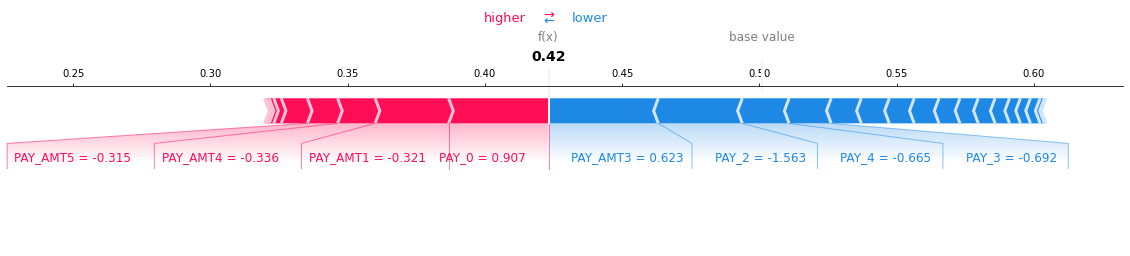

In [74]:
# Round for more readable plots
X_test_enc_sample = X_test_enc_sample.round(3)
shap.force_plot(
    forest_explainer.expected_value[1],
    forest_test_shap_values[1][82],
    X_test_enc_sample.iloc[82, :],
    matplotlib=True,
)

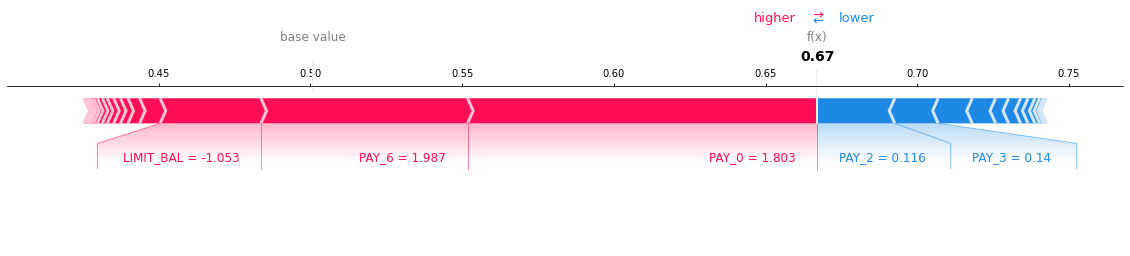

In [75]:
shap.force_plot(
    forest_explainer.expected_value[1],
    forest_test_shap_values[1][0],
    X_test_enc_sample.iloc[0, :],
    matplotlib=True,
)

In [76]:
pd.DataFrame(X_test_enc_sample.iloc[82, :]).T

LIMIT_BAL    AGE  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  \
28570     -0.668 -0.702  0.907 -1.563 -0.692 -0.665 -0.648  -1.48     -0.696   

       BILL_AMT2  ...  PAY_AMT5  PAY_AMT6  MARRIAGE_Married  MARRIAGE_Other  \
28570     -0.689  ...    -0.315    -0.187               0.0             0.0   

       MARRIAGE_Single  EDUCATION_Grad_school  EDUCATION_High_school  \
28570              1.0                    1.0                    0.0   

       EDUCATION_Other  EDUCATION_University  SEX_Male  
28570              0.0                   0.0       0.0  

[1 rows x 28 columns]

In [77]:
forest_pipe_tuned.named_steps["randomforestclassifier"].predict(X_test_enc_sample)

X has feature names, but RandomForestClassifier was fitted without feature names


array([1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

**Answer 12.3** 

<br><br>

## 13. Summary of results <a name="13"></a>
<hr>
rubric={reasoning:12}

Imagine that you want to present the summary of these results to your boss and co-workers. 

**Your tasks:**

1. Create a table summarizing important results. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 
3. Report your final test score along with the metric you used at the top of this notebook in the [Submission instructions section](#si).

In [80]:
ind = {'test_accuracy' : 'accuracy', 
       'test_f1' :'f1', 
       'test_recall' :'recall', 
       'test_precision':'precision', 
       'test_roc_auc' :'roc_auc'}

# extract CV scores from training
train_scores = pd.DataFrame(results["randomforest tuned"], columns = ["Training Data"]).iloc[2::2, :].rename(index = ind)
test_scores = pd.DataFrame(score_dict).T.rename(columns = {0: "Test Data"})

final_df = pd.concat([train_scores, test_scores], axis = 1)
final_df


Training Data  Test Data
accuracy   0.786 (+/- 0.005)   0.768267
f1         0.548 (+/- 0.011)   0.516282
recall     0.579 (+/- 0.015)   0.566585
precision  0.520 (+/- 0.010)   0.474182
roc_auc    0.777 (+/- 0.006)   0.765482

**Concluding remarks** 

In the training phase (post-hyperparameter optimization), RandomForestClassifier performed the best out of all the models tested; it had the best validation scores in terms of recall, precision, and ROC AUC. The best hyperparameters for RandomForestClassifier were a balanced class weight, 60 estimators,  0.1 max_features, and a max tree depth of 8. Again, it is important to note that ensembles, such as RandomForestClassifier, "beat" the fundamental tradeoff of model complexity vs. model fit by increasing train score without decreasing validation scores. Therefore, RandomForestClassifier was mainly picked because of it's potential to generalize well. 

As seen in the table above, the test scores are fairly similar to the CV scores of the training data. While this is good confirmation that RandomForestClassifier was able to generalize on unseen data, it does not mean that the model was able to identify fraud well. In the test data, we are left with a recall score that identifies fraud ~56% of the time, which is unsatisfactory to say the least.  

- SHAP takeaways
- Improvement/performance ideas


<br><br>

## (Optional) 14. Creating a data analysis pipeline <a name="14"></a>
rubric={reasoning:2}

**Your tasks:**
- In 522 you learned how build a reproducible data analysis pipeline. Convert this notebook into scripts and create a reproducible data analysis pipeline with appropriate documentation. 

<br><br>

## (Optional) 15. Your takeaway from the course <a name="15"></a>
<hr>
rubric={reasoning:1}

**Your tasks:**

What is your biggest takeaway from this course? 


<br><br>

**PLEASE READ BEFORE YOU SUBMIT:** 

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Push all your work to your GitHub lab repository. 
4. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope. 

Well done!! Have a great weekend! 

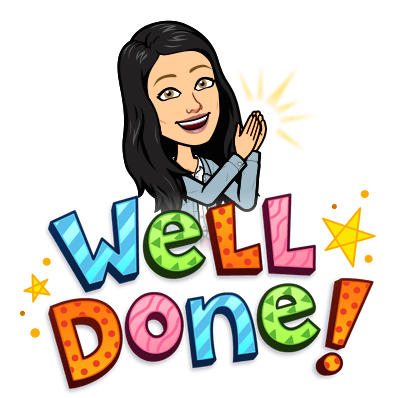

In [79]:
from IPython.display import Image

Image("eva-well-done.png")